# ECSE 551 Assignment 3

In [1]:
from google.colab import drive

# General libraries
import pickle
import numpy as np
import cv2 as cv
import random as rd
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import skimage.transform as st
from google.colab import files 

# Torch libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset

# Scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA

drive.mount('/content/gdrive')
data_path = './gdrive/MyDrive/ECSE_551_Assignment_3/Data/'
model_path = './gdrive/MyDrive/ECSE_551_Assignment_3/Models/'

Mounted at /content/gdrive


In [2]:
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Loading Data

In [3]:
train_data = pickle.load(open(data_path + 'Train.pkl', 'rb'))
test_data = pickle.load(open(data_path + 'Test.pkl', 'rb'))
train_targets = np.genfromtxt(data_path + 'Train_labels.csv', delimiter=',')
train_targets = train_targets[1:60001,1]
# data = np.squeeze(data,axis=1)

print("Number of train data: " + str(train_data.shape[0]))
print("Number of train targets: " + str(train_targets.shape[0]))
print("Number of test data: " + str(test_data.shape[0]))
print("Dimensions of a sample:", train_data.shape[1:])

print("Type of the dataset:", type(train_data))
print("Atomic datatype:", train_data.dtype)

Number of train data: 60000
Number of train targets: 60000
Number of test data: 10000
Dimensions of a sample: (1, 28, 28)
Type of the dataset: <class 'numpy.ndarray'>
Atomic datatype: float32


## Dataset

In [4]:
def plt_grid(train_data, indices, label_on = True):
  fig, axarr = plt.subplots(3,3, figsize=(12,12)) 
  index = 0
  for ax in axarr.flat:
      ax.matshow(train_data[indices[index]][0], cmap='gray', interpolation="bicubic")
      ax.axis('off')
      if label_on:
        ax.set_title('Label: {}'.format(int(train_targets[indices[index]])))
      index += 1
  if not label_on:
    plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

Sample training images:


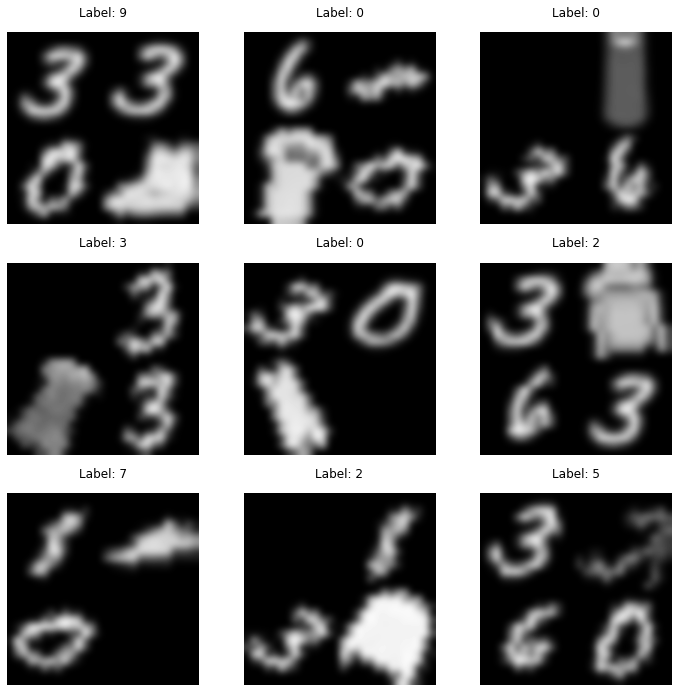

In [5]:
print("Sample training images:")
plt_grid(train_data, range(0,9))

Sample training images where the label is 0 :


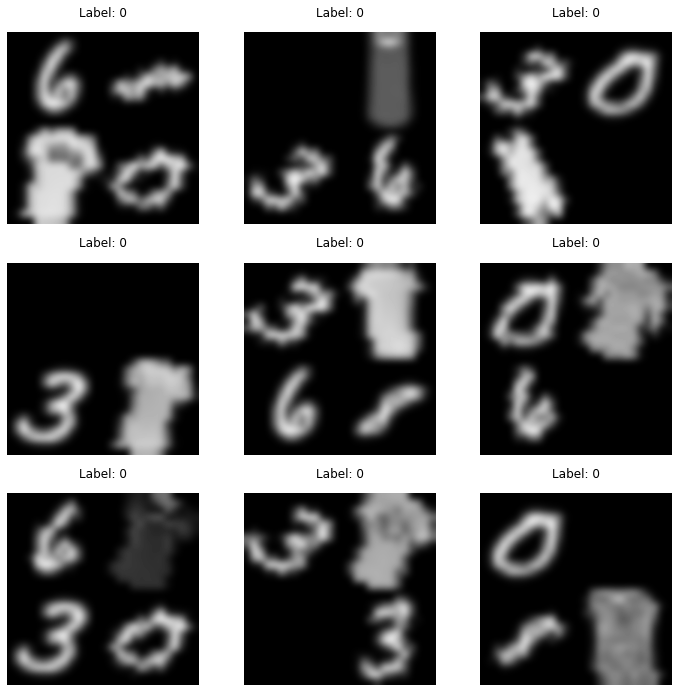

In [6]:
label = 0
indices = np.argwhere(train_targets == label)[:9][:,0]

print("Sample training images where the label is", label, ":")
plt_grid(train_data, indices)

In [7]:
print("Minimum Pixel Intensity:", train_data.min())
print("Maximum Pixel Intensity:", train_data.max())
print("Mean Pixel Intensity:", train_data.mean())
print("Pixel Intensity Std:", train_data.std())

Minimum Pixel Intensity: 0.0
Maximum Pixel Intensity: 1.0
Mean Pixel Intensity: 0.15535328
Pixel Intensity Std: 0.26992422


In [8]:
sample_resized_alexnet = np.array([cv.resize(img,(227,227)) for img in train_data[:30]]) # default bilinear
print("Minimum Pixel Intensity:", sample_resized_alexnet.min())
print("Maximum Pixel Intensity:", sample_resized_alexnet.max())
print("Mean Pixel Intensity:", sample_resized_alexnet.mean())
print("Pixel Intensity Std:", sample_resized_alexnet.std())

Minimum Pixel Intensity: 0.0
Maximum Pixel Intensity: 0.9567678
Mean Pixel Intensity: 0.1626857
Pixel Intensity Std: 0.26509982


## Preprocessing

### Cropping Quadrants

In [9]:
qd1 = train_data[:,:,:14,14:].copy()
qd2 = train_data[:,:,14:,14:].copy()
qd3 = train_data[:,:,14:,:14].copy()
qd4 = train_data[:,:,:14,:14].copy()

qd1_t = test_data[:,:,:14,14:].copy()
qd2_t = test_data[:,:,14:,14:].copy()
qd3_t = test_data[:,:,14:,:14].copy()
qd4_t = test_data[:,:,:14,:14].copy()

qds = np.concatenate([qd1,qd2,qd3,qd4])
qds_t = np.concatenate([qd1_t,qd2_t,qd3_t,qd4_t])

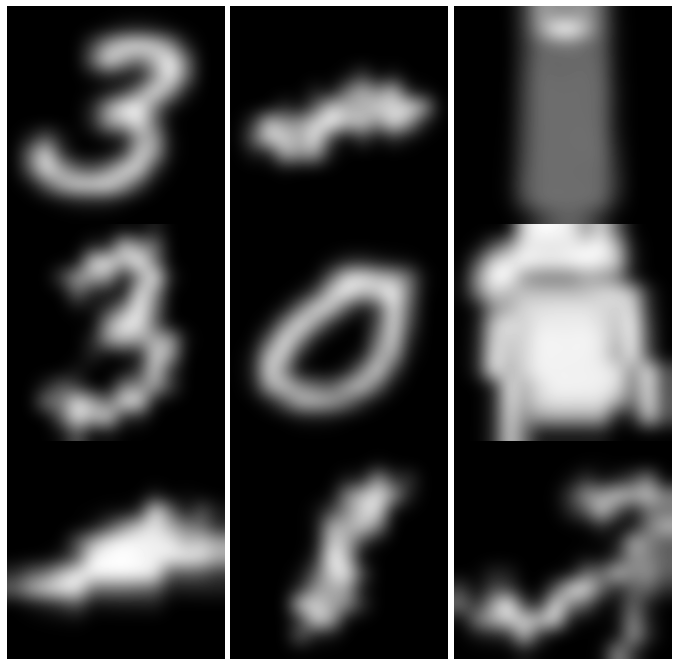

In [10]:
plt_grid(qd1, range(0,9), False)

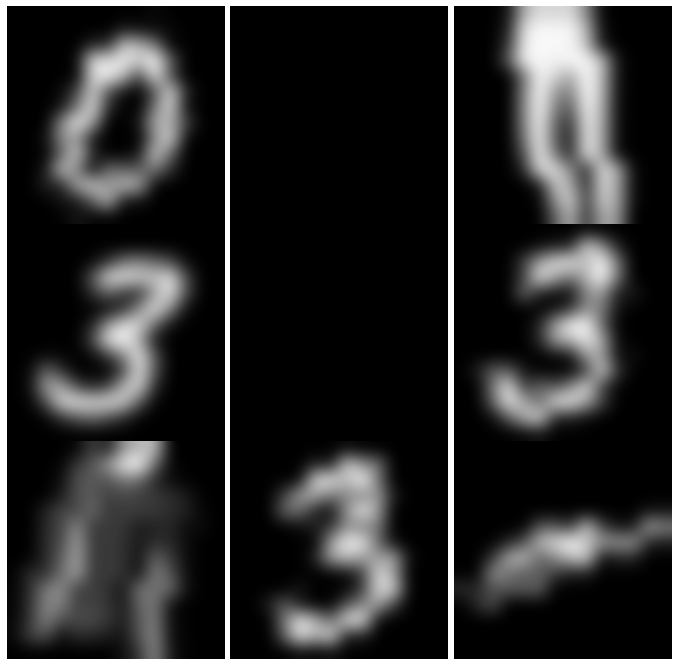

In [11]:
plt_grid(qd1_t, range(0,9), False)

## PCA Dimention Reduction

In [12]:
def normalize(data):
  data = data - data.mean()
  return (data/data.std())

In [13]:
# Flatten Training
flatten_qds = qds[:,0,:,:].reshape(len(qds), -1) * 255
flatten_qds = normalize(flatten_qds)

# Flatten Test
flatten_qds_t = qds_t[:,0,:,:].reshape(len(qds_t), -1) * 255
flatten_qds_t = normalize(flatten_qds_t)

# Dimention Reduction
pca = PCA(0.95)
redu_qds = pca.fit_transform(flatten_qds)
pca = PCA(0.95)
redu_qds_t = pca.fit_transform(flatten_qds_t)

In [16]:
gm = GaussianMixture(n_components=3, tol=1e-3, random_state=0)
gm.fit(redu_qds)
qds_gm_labels = gm.predict(redu_qds)

gm = GaussianMixture(n_components=3, tol=1e-3, random_state=0)
gm.fit(redu_qds_t)
qds_gm_t_labels = gm.predict(redu_qds_t)

In [18]:
qd1_gm_labels = qds_gm_labels[0:60000].copy()
qd2_gm_labels = qds_gm_labels[60000:120000].copy()
qd3_gm_labels = qds_gm_labels[120000:180000].copy()
qd4_gm_labels = qds_gm_labels[180000:240000].copy()

qd1_t_gm_labels = qds_gm_t_labels[0:10000].copy()
qd2_t_gm_labels = qds_gm_t_labels[10000:20000].copy()
qd3_t_gm_labels = qds_gm_t_labels[20000:30000].copy()
qd4_t_gm_labels = qds_gm_t_labels[30000:40000].copy()

In [19]:
np.bincount(qds_gm_labels)

array([83199, 60000, 96801])

In [20]:
np.bincount(qds_gm_t_labels)

array([13972, 16028, 10000])

In [21]:
fashion_imgs = []
digits_imgs = []
conflict_count = 0
for i in range(60000):
  fashion_index = qd1_gm_labels[2]
  labels = np.array([qd1_gm_labels[i],
                     qd2_gm_labels[i],
                     qd3_gm_labels[i],
                     qd4_gm_labels[i]])
  qds = [qd1[i], qd2[i], qd3[i], qd4[i]]
  
  indices = np.argwhere(labels == fashion_index)
  if(indices.size == 1):
    fashion_imgs.append(qds[indices[0,0]])
  else:
    confict_count += 1
    fashion_imgs.append(qds[indices[0,0]])

print("Number of conflict images (hard to classify): ", conflict_count)

Number of conflict images (hard to classify):  0


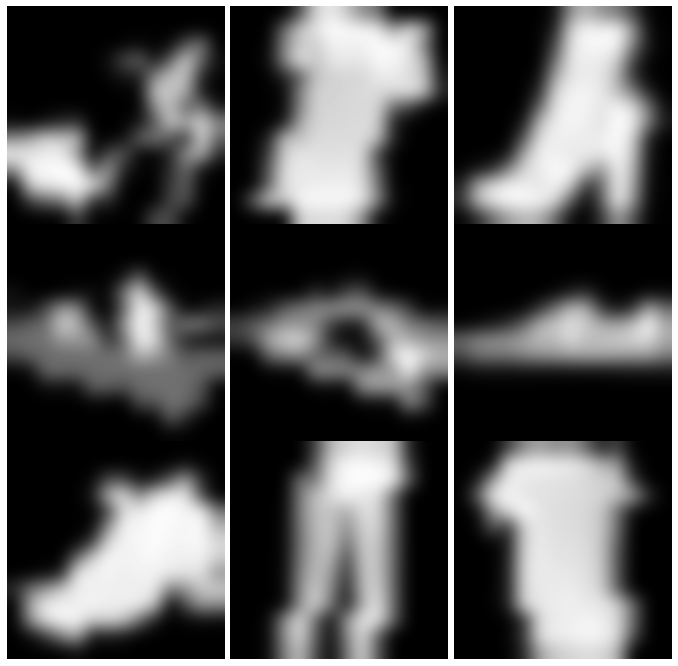

In [22]:
fashion_imgs = np.array(fashion_imgs)
plt_grid(fashion_imgs, range(9,18), False)

In [23]:
data = torch.from_numpy(fashion_imgs)
targets = torch.from_numpy(train_targets)

dataset = TensorDataset(data,targets)

In [24]:
print("Minimum Pixel Intensity:", fashion_imgs.min())
print("Maximum Pixel Intensity:", fashion_imgs.max())
print("Mean Pixel Intensity:", fashion_imgs.mean())
print("Pixel Intensity Std:", fashion_imgs.std())

Minimum Pixel Intensity: 0.0
Maximum Pixel Intensity: 1.0
Mean Pixel Intensity: 0.28505665
Pixel Intensity Std: 0.31596282


In [26]:
np.bincount(qds_gm_t_labels)

array([13972, 16028, 10000])

In [27]:
fashion_imgs_test = []
conflict_count = 0
for i in range(10000):
  fashion_index = qd1_t_gm_labels[2]
  labels = np.array([qd1_t_gm_labels[i],
                     qd2_t_gm_labels[i],
                     qd3_t_gm_labels[i],
                     qd4_t_gm_labels[i]])
  qds_t = [qd1_t[i], qd2_t[i], qd3_t[i], qd4_t[i]]
  
  indices = np.argwhere(labels == fashion_index)
  if(indices.size == 1):
    fashion_imgs_test.append(qds_t[indices[0,0]])
  else:
    confict_count += 1
    fashion_imgs.append(qds_t[indices[0,0]])

print("Number of conflict images (hard to classify): ", conflict_count)

Number of conflict images (hard to classify):  0


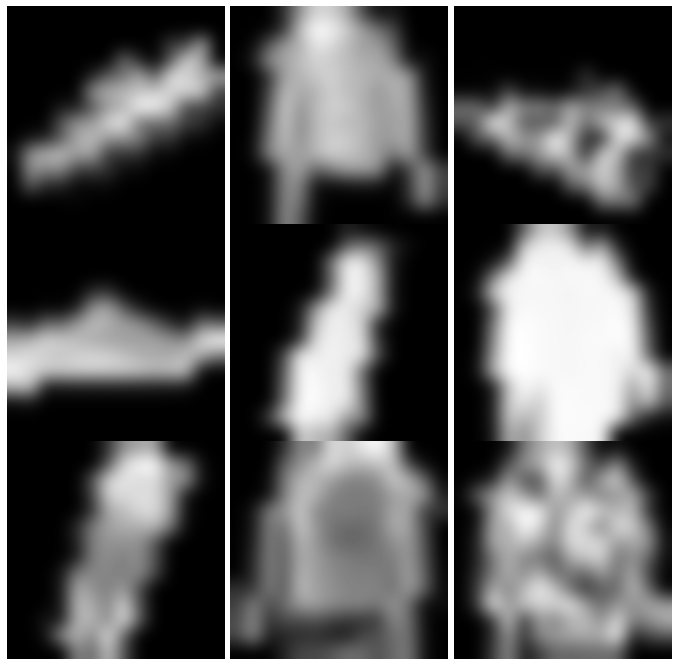

In [28]:
fashion_imgs_test = np.array(fashion_imgs_test)
plt_grid(fashion_imgs_test, range(9,18), False)

In [29]:
MEAN = 0.28505665
STD = 0.31596282

## Model

In [30]:
class Dataset():
    def __init__(self, my_dataset, transform=None, is_test = False):        
        self.dataset = my_dataset
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx][0]
        if(self.is_test != True):
           label = self.dataset[idx][1]
        else:
           label = torch.empty((1,1), dtype=torch.int32)
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            image = self.transform(image)
            
        return image, label

In [33]:
SimpleNetTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((MEAN,), (STD,))
])

In [34]:
transform = SimpleNetTransform
batch_size = 50 #feel free to change it

In [35]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [55000, 5000])

train_dataloader = DataLoader(Dataset(train_dataset, transform=SimpleNetTransform),batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(Dataset(val_dataset, transform=transform),batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(Dataset(fashion_imgs_test, transform=transform, is_test = True),batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


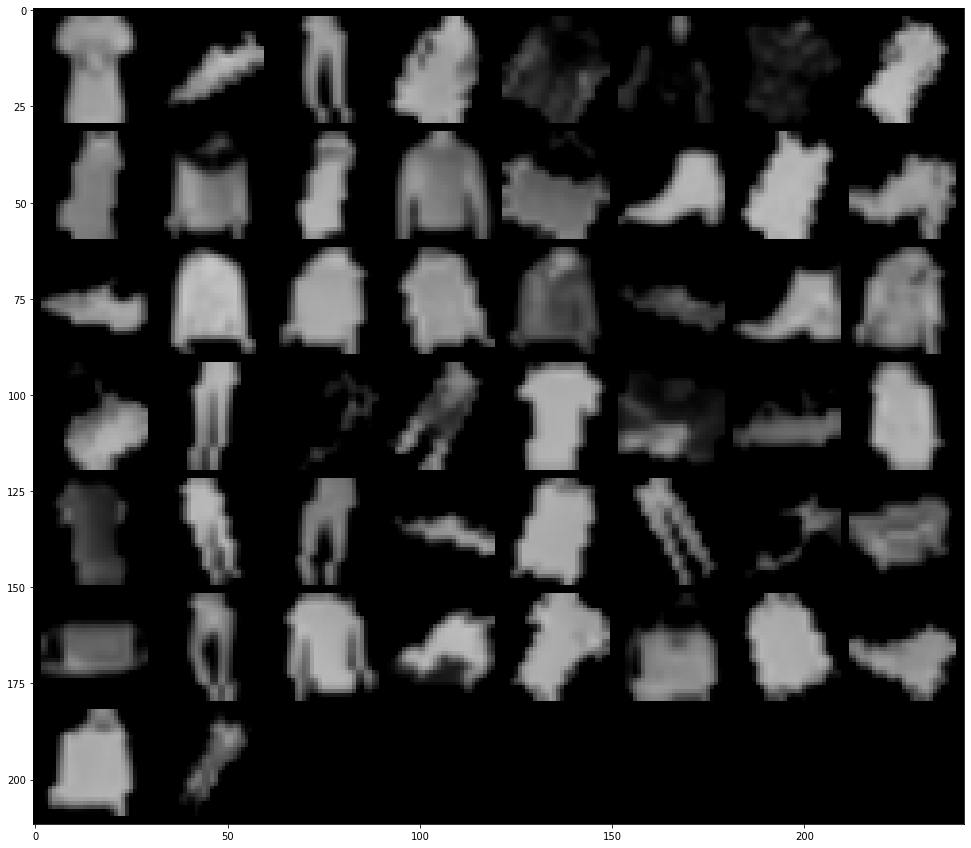

In [36]:
# Read a batch of data and their labels and display them

[imgs, labels] = (next(iter(train_dataloader)))
# imgs = np.squeeze(imgs)
# plt.imshow(imgs[50].numpy(),cmap='gray',interpolation="bicubic") #.transpose()
img_grid = torchvision.utils.make_grid((imgs + MEAN)*STD)

plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0), cmap='gray')
plt.show()

In [37]:
print(labels)

tensor([0., 7., 1., 4., 6., 6., 6., 3., 0., 4., 3., 4., 8., 9., 6., 9., 7., 4.,
        4., 4., 4., 7., 9., 4., 8., 1., 5., 1., 0., 8., 5., 4., 0., 1., 1., 7.,
        2., 1., 5., 8., 8., 1., 2., 5., 0., 8., 4., 9., 4., 1.],
       dtype=torch.float64)


In [38]:
# training batches of our network
EPOCHS = 100

In [41]:
class VGG_Basic(nn.Module):
    def __init__(self):
        super(VGG_Basic, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 'same')
        self.conv4 = nn.Conv2d(128, 256, kernel_size = 3, padding = 'same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        x = self.maxpool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        return x

In [42]:
class VGG_Ver2(nn.Module):
    def __init__(self):
        super(VGG_Ver2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.conv5 = nn.Conv2d(64, 128, kernel_size = 3, padding = 'same')
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3, padding = 'same')
        self.conv6 = nn.Conv2d(128, 128, kernel_size = 3, padding = 'same')
        self.conv7 = nn.Conv2d(128, 256, kernel_size = 3, padding = 'same')
        self.conv8 = nn.Conv2d(256, 256, kernel_size = 3, padding = 'same')
        self.conv8 = nn.Conv2d(256, 256, kernel_size = 3, padding = 'same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.maxpool(F.relu(self.conv8(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        return x

In [43]:
class VGG_Ver3(nn.Module):
    def __init__(self):
        super(VGG_Ver3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, padding = 'same')
        self.conv5 = nn.Conv2d(128, 128, kernel_size = 3, padding = 'same')
        self.conv6 = nn.Conv2d(128, 256, kernel_size = 3, padding = 'same')
        self.conv7 = nn.Conv2d(256, 256, kernel_size = 3, padding = 'same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.maxpool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = self.maxpool(F.relu(self.conv8(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        return x

In [73]:
class MyConvNet1(nn.Module):
    def __init__(self):
        super(MyConvNet1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding='same')
        self.fc1 = nn.Linear(1152, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [46]:
class MyConvNet2(nn.Module):
    def __init__(self):
        super(MyConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding='same')
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=1)

In [47]:
class MyConvNet3(nn.Module):
    def __init__(self):
        super(MyConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.pool = nn.MaxPool2d(2, padding=0, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding='same')
        self.fc1 = nn.Linear(2048, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

In [48]:
class MyConvNet4(nn.Module):
    def __init__(self):
        super(MyConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.norm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, padding=0, ceil_mode=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1, padding='same')
        self.norm3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(2048, 1200)
        self.fc2 = nn.Linear(1200, 10)

    def forward(self, x):
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

In [92]:
from torchsummary import summary
model = VGG_Ver2().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 32, 28, 28]           9,248
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
            Conv2d-5           [-1, 64, 14, 14]          36,928
            Conv2d-6           [-1, 64, 14, 14]          36,928
         MaxPool2d-7             [-1, 64, 7, 7]               0
            Conv2d-8            [-1, 128, 7, 7]          73,856
            Conv2d-9            [-1, 128, 7, 7]         147,584
           Conv2d-10            [-1, 128, 7, 7]         147,584
        MaxPool2d-11            [-1, 128, 3, 3]               0
           Conv2d-12            [-1, 256, 3, 3]         295,168
           Conv2d-13            [-1, 256, 3, 3]         590,080
           Conv2d-14            [-1, 25

In [93]:
model = MyConvNet4().to(DEVICE)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
       BatchNorm2d-5           [-1, 64, 14, 14]             128
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]           8,320
       BatchNorm2d-8            [-1, 128, 7, 7]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                 [-1, 1200]       2,458,800
           Linear-11                   [-1, 10]          12,010
Total params: 2,498,394
Trainable params: 2,498,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [95]:
# Select model for training here
model = VGG_Ver2().to(DEVICE)
criterion_cel = nn.CrossEntropyLoss()
criterion_nll = nn.NLLLoss()
adam_optimizer = optim.Adam(model.parameters())
sgd_optimizer = optim.SGD(model.parameters(), lr=0.01,
                          momentum=0.5)

In [96]:
def train(model, epoch, train_loader, optimizer, criterion):

    correct_train_pred = 0
    train_loss = 0

    model.train()
    for train_batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad() # Clear the gradients
        torch.cuda.empty_cache()
        output = model(data)  # Forward pass
        loss = criterion(output, target) # Compute loss
        loss.backward()       # Backward propagation
        optimizer.step()      # Update weights

        _, pred = torch.max(output, 1)
        correct_train_pred += (pred == target).sum()

        train_loss += loss.item();

        if (train_batch_idx + 1) % 30 == 0:
          print("Epoch:{} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTrain accuracy: {:.2f}%".format(
                epoch, train_batch_idx * len(data), len(train_loader.dataset),
                100. * train_batch_idx / len(train_loader), loss.item(), 
                correct_train_pred.item() / (len(data) * (train_batch_idx + 1)) * 100))
    
    return train_loss / len(train_loader), correct_train_pred.item() / (len(data) * (train_batch_idx + 1)) * 100

In [97]:
def validate(model, val_loader, criterion):
  correct_val_pred = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for val_batch_index, (data, target) in enumerate(val_loader):
          target = target.type(torch.LongTensor).to(DEVICE)
          data, target = data.to(DEVICE), target.to(DEVICE)
          output = model(data)
          val_loss += criterion(output, target).item()
          _, pred = torch.max(output, 1)
          correct_val_pred += (pred == target).sum()
  
  accuracy = 100. * correct_val_pred.item() / (len(data) * len(val_loader))
  print('Test: Avg. loss: {:.6f}, Accuracy: {:.2f}%\n'.format(val_loss/len(val_loader.dataset), accuracy))
  
  return val_loss/len(val_loader), accuracy

In [98]:
train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []
for epoch in range(1, EPOCHS+1): 
  train_loss, train_acc = train(model,epoch,train_dataloader,sgd_optimizer,criterion_cel)
  val_loss, val_acc = validate(model, val_dataloader,criterion_cel)
  train_loss_arr.append(train_loss)
  train_acc_arr.append(train_acc)
  val_loss_arr.append(val_loss)
  val_acc_arr.append(val_acc)

Epoch:1 [1450/55000 (3%)]	Train Loss: 2.299659	Train accuracy: 9.27%
Epoch:1 [2950/55000 (5%)]	Train Loss: 2.295893	Train accuracy: 9.73%
Epoch:1 [4450/55000 (8%)]	Train Loss: 2.292915	Train accuracy: 9.64%
Epoch:1 [5950/55000 (11%)]	Train Loss: 2.296309	Train accuracy: 10.00%
Epoch:1 [7450/55000 (14%)]	Train Loss: 2.296571	Train accuracy: 10.00%
Epoch:1 [8950/55000 (16%)]	Train Loss: 2.302315	Train accuracy: 9.90%
Epoch:1 [10450/55000 (19%)]	Train Loss: 2.302385	Train accuracy: 9.95%
Epoch:1 [11950/55000 (22%)]	Train Loss: 2.302368	Train accuracy: 9.83%
Epoch:1 [13450/55000 (24%)]	Train Loss: 2.302823	Train accuracy: 9.90%
Epoch:1 [14950/55000 (27%)]	Train Loss: 2.301080	Train accuracy: 9.87%
Epoch:1 [16450/55000 (30%)]	Train Loss: 2.302123	Train accuracy: 9.97%
Epoch:1 [17950/55000 (33%)]	Train Loss: 2.300034	Train accuracy: 9.90%
Epoch:1 [19450/55000 (35%)]	Train Loss: 2.300211	Train accuracy: 9.90%
Epoch:1 [20950/55000 (38%)]	Train Loss: 2.308204	Train accuracy: 9.91%
Epoch:1 [2245

KeyboardInterrupt: ignored

In [78]:
np.save(model_path + 'No_dropout_MyConvNet1_train_loss.npy', np.array(train_loss_arr))
np.save(model_path + 'No_dropout_MyConvNet1_val_loss.npy', np.array(val_loss_arr))
np.save(model_path + 'No_dropout_MyConvNet1_train_acc.npy', np.array(train_acc_arr))
np.save(model_path + 'No_dropout_MyConvNet1_val_acc.npy', np.array(val_acc_arr))

In [657]:
torch.save(model.state_dict(), model_path + 'MyConvNet4_97_train_89_val.pt')

In [ ]:
model = Net().to(DEVICE)
model.load_state_dict(torch.load(model_path + 'net_71.pt'))

<All keys matched successfully>

In [658]:
pred_arr = []
model.eval()
with torch.no_grad():
  for data, target in test_dataloader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    pred = output.data.max(1, keepdim=True)[1]
    pred_arr.append(pred[0,0])

In [659]:
for i in range(len(pred_arr)):
  pred_arr[i] = pred_arr[i].cpu().item()

In [660]:
def download_csv(pred):
  output_df = pd.DataFrame(pred_arr, columns = ['class'])
  output_df.insert(0, 'id', output_df.index)
  output_df.to_csv("submission.csv", index=None)
  files.download('submission.csv')

In [661]:
download_csv(pred_arr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
dropout_train_acc =np.load(model_path + 'MyConvNet1_train_acc_final.npy')
dropout_val_acc = np.load(model_path + 'MyConvNet1_val_acc_final.npy')
dropout_train_loss = np.load(model_path + 'MyConvNet1_train_loss_final.npy')
dropout_val_loss = np.load(model_path + 'MyConvNet1_val_loss_final.npy')

no_dropout_train_acc =np.load(model_path + 'No_dropout_MyConvNet1_train_acc.npy')
no_dropout_val_acc = np.load(model_path + 'No_dropout_MyConvNet1_val_acc.npy')
no_dropout_train_loss = np.load(model_path + 'No_dropout_MyConvNet1_train_loss.npy')
no_dropout_val_loss = np.load(model_path + 'No_dropout_MyConvNet1_val_loss.npy')

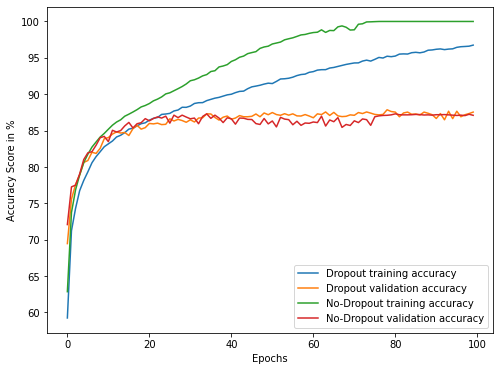

In [80]:
plt.figure(figsize=(8,6))

plt1 = plt.plot(dropout_train_acc)
plt1 = plt.plot(dropout_val_acc)

plt1 = plt.plot(no_dropout_train_acc)
plt1 = plt.plot(no_dropout_val_acc)

plt.xlabel('Epochs')
plt.ylabel('Accuracy Score in %')

plt.legend(['Dropout training accuracy','Dropout validation accuracy','No-Dropout training accuracy', 'No-Dropout validation accuracy'])

plt.show()

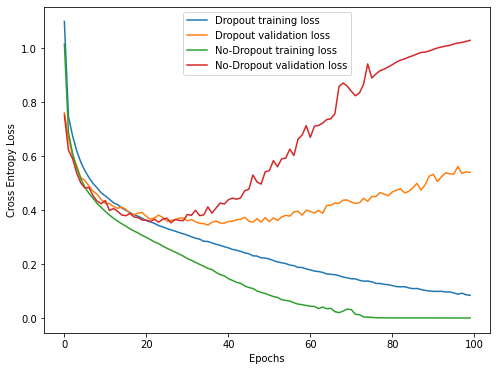

In [81]:
plt.figure(figsize=(8,6))

plt1 = plt.plot(dropout_train_loss)
plt1 = plt.plot(dropout_val_loss)

plt1 = plt.plot(no_dropout_train_loss)
plt1 = plt.plot(no_dropout_val_loss)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

plt.legend(['Dropout training loss','Dropout validation loss','No-Dropout training loss', 'No-Dropout validation loss'])

plt.show()

In [26]:
ver3_train_acc =np.load(model_path + 'MyConvNet3_train_acc.npy')
ver3_val_acc = np.load(model_path + 'MyConvNet3_val_acc.npy')
ver3_train_loss = np.load(model_path + 'MyConvNet3_train_loss.npy')
ver3_val_loss = np.load(model_path + 'MyConvNet3_val_loss.npy')

ver2_train_acc =np.load(model_path + 'myconv2_train_acc.npy')
ver2_val_acc = np.load(model_path + 'myconv2_val_acc.npy')
ver2_train_loss = np.load(model_path + 'myconv2_train_loss.npy')
ver2_val_loss = np.load(model_path + 'myconv2_val_loss.npy')

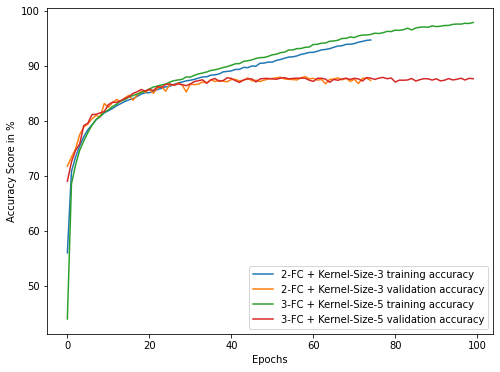

In [35]:
plt.figure(figsize=(8,6))

plt1 = plt.plot(ver3_train_acc)
plt1 = plt.plot(ver3_val_acc)

plt1 = plt.plot(ver2_train_acc)
plt1 = plt.plot(ver2_val_acc)

plt.xlabel('Epochs')
plt.ylabel('Accuracy Score in %')

plt.legend(['2-FC + Kernel-Size-3 training accuracy','2-FC + Kernel-Size-3 validation accuracy','3-FC + Kernel-Size-5 training accuracy', '3-FC + Kernel-Size-5 validation accuracy'])

plt.show()
# plt2 = plt.plot(batch_train_loss)
# plt2 = plt.plot(batch_val_loss)

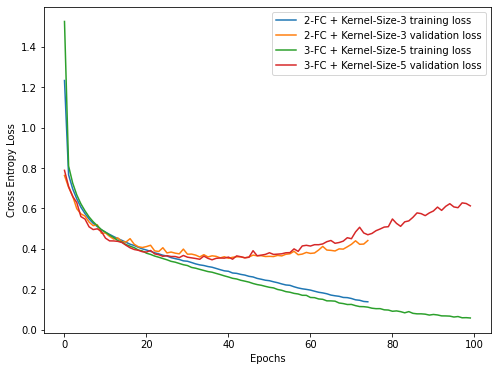

In [38]:
plt.figure(figsize=(8,6))

plt1 = plt.plot(ver3_train_loss)
plt1 = plt.plot(ver3_val_loss)

plt1 = plt.plot(ver2_train_loss)
plt1 = plt.plot(ver2_val_loss)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

plt.legend(['2-FC + Kernel-Size-3 training loss','2-FC + Kernel-Size-3 validation loss','3-FC + Kernel-Size-5 training loss', '3-FC + Kernel-Size-5 validation loss'])

plt.show()

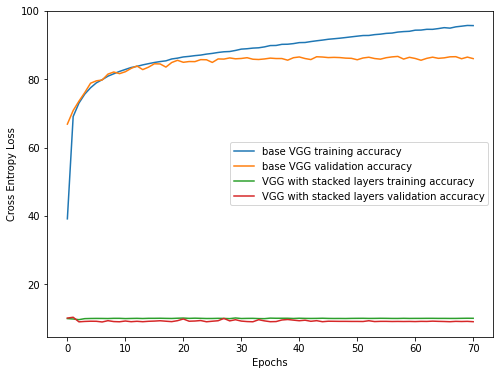

In [103]:
plt.figure(figsize=(8,6))

plt1 = plt.plot(vgg1_train_acc_arr)
plt1 = plt.plot(vgg1_val_acc_arr)

plt1 = plt.plot(vgg2_train_acc_arr)
plt1 = plt.plot(vgg2_val_acc_arr)

plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')

plt.legend(['base VGG training accuracy','base VGG validation accuracy','VGG with stacked layers training accuracy', 'VGG with stacked layers validation accuracy'])

plt.show()